In [0]:
import matplotlib.pyplot as plt
import numpy as np
import sys

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

0it [00:00, ?it/s]

169009152it [00:02, 65632305.63it/s]                               


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Done!

Creating dataloaders...
Done!

Dataset statistics:
  Trainset size = 50000
  Testset size = 10000
  Number of classes = 100

Samples:


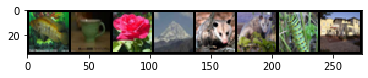

['aquarium_fish', 'cup', 'rose', 'mountain', 'possum', 'possum', 'caterpillar', 'house']

Setting up device conf...
Using device: cuda:0


In [2]:
batch_size = 100

transform = T.Compose([
                       T.ToTensor(),
                       T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print('Downloading dataset...')
trainset = torchvision.datasets.CIFAR100(root='./data',
                                         train=True,
                                         download=True,
                                         transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data',
                                        train=False, 
                                        download=True,
                                        transform=transform)
print('Done!\n')

print('Creating dataloaders...')
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         num_workers=4,
                                         shuffle=True)
print('Done!\n')

sizes = dict()
sizes['train'] = len(trainset)
sizes['test'] = len(testset)
classes = testset.classes

print('Dataset statistics:')
print('  Trainset size = {}'.format(sizes['train']))
print('  Testset size = {}'.format(sizes['test']))
print('  Number of classes = {}'.format(len(classes)))

print()
print('Samples:')

def imshow(img):
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1, 2, 0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:8] / 2 + 0.5))
gt_labels = [classes[l] for l in labels[:8]]
print(gt_labels)

print()
print('Setting up device conf...')
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
print('Using device: {}'.format(device))

In [0]:
def progress_bar(iteration, total, length=100, prefix='', suffix=''):
  percentage = iteration / total
  completed = int(percentage * length)
  progress_bar = '|'+ '-'*completed + '>' + ' '*(length-completed)+'|'
  progress_perc = ' {:.2f}% '.format(100*percentage)
  return str(prefix + ' ' + progress_bar + progress_perc + suffix)

def predict(model, data, loss_fn):
  images, labels = data

  images = images.to(device)
  labels = labels.to(device)
  
  # forward pass: model makes prediction
  out = model(images)

  # computes loss and accuracy
  loss = loss_fn(out, labels)
  _, pred = torch.max(out, 1)
  total = labels.shape[0]
  correct = (pred == labels).sum().item()

  # returns statistics
  return loss, total, correct 

def train_epoch(model, optimizer, trainloader):
  # reset epoch statistics
  running_loss = 0.0
  total, correct = 0.0, 0.0
  it_per_epoch = len(trainloader)

  for iteration, data in enumerate(trainloader, 1):
    # training step
    optimizer.zero_grad()
    loss, total_step, correct_step = predict(model, data, loss_fn)
    loss.backward()
    optimizer.step()

    # update statistics
    total += total_step
    correct += correct_step
    running_loss += loss.item()

    # print info
    loss_msg = 'Running Loss: {:.4f}'.format(running_loss / iteration)
    print(progress_bar(iteration, it_per_epoch, suffix=loss_msg), end='\r')
    sys.stdout.flush()
  else:
    loss_msg = 'Epoch Loss: {:.4f}'.format(running_loss / it_per_epoch)
    print(progress_bar(it_per_epoch, it_per_epoch, suffix=loss_msg))

  return 100*correct/total

def evaluate(model, testloader):
  running_loss = 0.0
  total, correct = 0.0, 0.0
  it_test = len(testloader)

  for iteration, data in enumerate(testloader, 1):
    # forward function
    loss, total_step, correct_step = predict(model, data, loss_fn)

    # update statistics
    total += total_step
    correct += correct_step
    running_loss += loss.item()

    # print info
    loss_msg = 'Running Loss: {:.4f}'.format(running_loss / iteration)
    print(progress_bar(iteration, it_test, suffix=loss_msg), end='\r')
    sys.stdout.flush()
  else:
    loss_msg = 'Test Loss: {:.4f}'.format(running_loss / it_test)
    print(progress_bar(it_test, it_test, suffix=loss_msg))

  return 100*correct/total

In [0]:
class ConvBlock(nn.Module):
  # This is an implementation for a custom
  # [Conv + Norm + Relu]*2 + MaxPool block
  def __init__(self, channel_in, channel_h, channel_out,
               kernel_size=3, stride=1, padding=1, activation=nn.ReLU()):
    # __init__ method creates the instance of the class
    # all attributes are denoted with the self.'name' notation
    super(ConvBlock, self).__init__()
    self.conv1 = nn.Conv2d(channel_in, channel_h, kernel_size,
                           stride=stride, padding=padding)
    self.conv2 = nn.Conv2d(channel_h, channel_out, kernel_size,
                           stride=stride, padding=padding)
    # self.batch_norm_1 = nn.BatchNorm2d(num_features=channel_h)
    # self.batch_norm_2 = nn.BatchNorm2d(num_features=channel_out)
    self.activation = activation
    self.max_pool = nn.MaxPool2d((2,2))

  def forward(self, x):
    # the forward pass of the network is implemented in this method
    # here you can use the module created in the __init__() method
    # in this case, the input 'x' is sequentially forwarded to all the modules
    x = self.conv1(x)
    # x = self.batch_norm_1(x)
    x = self.activation(x)
    x = self.conv2(x)
    # x = self.batch_norm_2(x)
    x = self.activation(x)
    x = self.max_pool(x)
    return x

from typing import List

class MLP(nn.Module):
  # A custom implementation of a multi-layer perceptron with an arbitrary number of layers
  # one should specify a list of integer numbers
  # (e.g. [512, 256, 64, 10] or [1024, 100])
  def __init__(self, layer_size_list: List[int],
               activation=nn.ReLU(), drop_prob=None):
    super(MLP, self).__init__()
    sizes = layer_size_list
    self.fc_layers = nn.ModuleList(
            [nn.Linear(in_features=in_size, out_features=out_size)
              for in_size, out_size in zip(sizes[:-1], sizes[1:])]
          )
    self.activation = activation
    self.flatten = nn.Flatten()

    if drop_prob is None:
      self.dropout = None
    else:
      assert 0 < drop_prob < 1, 'Dropout probability must be in range (0,1)'
      self.dropout = nn.Dropout(p=drop_prob)

  def forward(self, x):
    # a more sophisticated forward function to deal with an arbitrary number of layers
    # in general, forward function can be arbitrarily complex
    x = self.flatten(x)

    for i, layer in enumerate(self.fc_layers):
      if self.dropout is not None and i != 0:
        x = self.dropout(x)
      x = layer(x)
      x = self.activation(x)

    return x

In [0]:
output_size = len(classes)
learning_rate = 1e-2

model = nn.Sequential(
    ConvBlock(channel_in=3, channel_h=32, channel_out=64,
              kernel_size=3, stride=1, padding=1, activation=nn.ReLU()),
    ConvBlock(channel_in=64, channel_h=128, channel_out=128,
              kernel_size=3, stride=1, padding=1, activation=nn.ReLU()),
    MLP(layer_size_list=[8*8*128, 1024, output_size],
        activation=nn.ReLU(), drop_prob=0.5)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
                            momentum=0.9, nesterov=True)

In [6]:
num_epoch = 10
eval_every = 2

for epoch in range(num_epoch):
  model.train()
  print('Starting Epoch {}/{}...'.format(epoch+1, num_epoch))
  accuracy = train_epoch(model, optimizer, trainloader)
  print('Epoch {} - Accuracy: {:.2f}%'.format(epoch+1, accuracy))

  if epoch % eval_every == eval_every - 1: 
    model.eval()
    with torch.no_grad():
      print('Evaluating model...')
      accuracy = evaluate(model, testloader)
      print('Test accuracy: {:.2f}%'.format(accuracy))
  
print('Finished training')

Starting Epoch 1/10...
 |---------------------------------------------------------------------------------------------------->| 100.00% Epoch Loss: 4.4086
Epoch 1 - Accuracy: 4.03%
Starting Epoch 2/10...
 |---------------------------------------------------------------------------------------------------->| 100.00% Epoch Loss: 3.7610
Epoch 2 - Accuracy: 12.74%
Evaluating model...
 |---------------------------------------------------------------------------------------------------->| 100.00% Test Loss: 3.4369
Test accuracy: 18.70%
Starting Epoch 3/10...
 |---------------------------------------------------------------------------------------------------->| 100.00% Epoch Loss: 3.3055
Epoch 3 - Accuracy: 20.56%
Starting Epoch 4/10...
 |---------------------------------------------------------------------------------------------------->| 100.00% Epoch Loss: 2.8982
Epoch 4 - Accuracy: 28.24%
Evaluating model...
 |------------------------------------------------------------------------------

Evaluating model...
 |---------------------------------------------------------------------------------------------------->| 100.00% Test Loss: 2.3711
Test accuracy: 43.77%
Showing qualitative results...


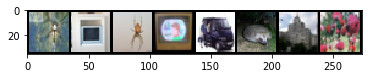

predicted labels: 	 ['kangaroo', 'television', 'spider', 'television', 'bus', 'trout', 'castle', 'poppy']
ground-truth labels: 	 ['spider', 'television', 'spider', 'television', 'bus', 'porcupine', 'castle', 'poppy']


In [7]:
model.eval()
with torch.no_grad():
  print('Evaluating model...')
  accuracy = evaluate(model, testloader)
  print('Test accuracy: {:.2f}%'.format(accuracy))

  print ('Showing qualitative results...')
  dataiter = iter(testloader)
  images, labels = dataiter.next()
  images = images.to(device)
  labels = labels.to(device)

  out = model(images)
  _, pred = torch.max(out, 1)

  imshow(torchvision.utils.make_grid(images.cpu()[:8] / 2 + 0.5))
  print('predicted labels: \t {}'.format([classes[p] for p in pred[:8]]))
  print('ground-truth labels: \t {}'.format([classes[l] for l in labels[:8]]))